<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLAMA3 Fine-tuning for text classification using QLORA


### Requirements:
* A GPU with enough memory!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

In [1]:
# Install Pytorch
%pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121
# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Sentiment Analysis Classification:


#### 1. Text Generation with Sentiment Label as part of text
- **Approach**: Train the model to generate text that naturally appends the sentiment label at the end.
- **Input**: "TSLA slashes model Y prices ======"
- **Output**: "TSLA slashes model Y prices ====== Bearish"
- **Use Case**: This method is useful for applications requiring continuous text output that includes embedded sentiment analysis, such as interactive chatbots or automated content creation tools.


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "TSLA slashes Model Y prices").
- **Output**: Direct sentiment classification (e.g., "Bearish").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [2]:
import os
import re
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
import bitsandbytes

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


c:\Users\lh5938a\Desktop\CTP\ctp_env_new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Youtube Video Describing How to get Dataset
* Only really need first 3 mins of video

#### Load TSLA sentiment analysis dataset
* Derived from Alpha vantage text data...
### SWAP WITH OUR DATA

In [4]:
%cd ..

c:\Users\lh5938a\Desktop\CTP


In [5]:
df = pd.read_csv("Data/llama/train_PT_date_5000_llama.csv")
df.head()

,text
0,<s>[INST]<<SYS>>Predict if this trial will tra...
1,<s>[INST]<<SYS>>Predict if this trial will tra...
2,<s>[INST]<<SYS>>Predict if this trial will tra...
3,<s>[INST]<<SYS>>Predict if this trial will tra...
4,<s>[INST]<<SYS>>Predict if this trial will tra...


In [6]:
# create new data set to match closer to trial, result (yes or no)
# let's also seperate phase to have a more structured output

In [7]:
import pandas as pd
import re

def parse_trial_data(input_file, output_file):
    """
    Parse clinical trial data from a CSV file and save to a new CSV.
    
    Args:
        input_file (str): Path to input CSV file containing trial data
        output_file (str): Path to save the output CSV
    """
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Lists to store parsed data
    trial_infos = []
    results = []
    
    # Parse each row
    for text in df.iloc[:, 0]:  # Assume the data is in the first column
        # Extract the trial information
        trial_pattern = r'\[INST\]<<SYS>>.*?<\/SYS>>(.*?)\[\/INST\]'
        trial_match = re.search(trial_pattern, text, re.DOTALL)
        
        # Extract the result (Yes/No)
        result_pattern = r'\[\/INST\](.*?)<\/s>'
        result_match = re.search(result_pattern, text)
        
        if trial_match and result_match:
            trial_info = trial_match.group(1).strip()
            result = result_match.group(1).strip()
            
            trial_infos.append(trial_info)
            results.append(result)
        else:
            # Handle rows where pattern isn't found
            trial_infos.append(None)
            results.append(None)
    
    # Create new DataFrame
    output_df = pd.DataFrame({
        'trial_information': trial_infos,
        'result': results
    })
    
    # Remove any rows where parsing failed
    output_df = output_df.dropna()
    
    # Save to CSV
    output_df.to_csv(output_file, index=False)
    
    print(f"Successfully processed {len(output_df)} rows")
    print(f"Sample of first row:")
    print("\nTrial Information (truncated):", output_df['trial_information'].iloc[0][:100], "...")
    print("Result:", output_df['result'].iloc[0])
    
    return output_df

In [8]:
input_file = "Data/llama/train_PT_date_5000_llama.csv"    
output_file = "Data/llama/parsed_trials_5000_llama.csv" 

df = parse_trial_data(input_file, output_file)

Successfully processed 5000 rows
Sample of first row:

Trial Information (truncated): TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/TN-IBC); BRIEF: This is an open label, single arm, mult ...
Result: No


In [9]:
df = pd.read_csv("Data/llama/parsed_trials_5000_llama.csv")
df.head()

,trial_information,result
0,TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/T...,No
1,TRIAL NAME: Phase I - Safety/PK; BRIEF: The pu...,No
2,TRIAL NAME: Phase III - Open-Label Extension (...,Yes
3,TRIAL NAME: Phase II - M13-608 (CIAS); BRIEF: ...,No
4,TRIAL NAME: Phase II - w/Ruxolitinib (MF/Post-...,Yes


In [10]:
def structure_trial_information(text):
    """
    Keep original phase information but structure consistently
    """
    # The phase is important context for the model to understand progression
    # No need to remove "TRIAL NAME: Phase ..." part anymore
    
    # Just split and structure between name and brief
    if 'BRIEF:' in text:
        name, brief = text.split('BRIEF:', 1)
        name = name.strip(' ;')
        brief = brief.strip()
        
        return f"{name}\nBrief Description: {brief}"
    
    return text

# Keep original text column with consistent structure
df['trial_information'] = df['trial_information'].apply(structure_trial_information)

# Show example
print("\nExample structured text:")
print(df['trial_information'].iloc[0])


Example structured text:
TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/TN-IBC)
Brief Description: This is an open label, single arm, multi-centre phase II study to assess the anti-tumour activity and safety of bemcentinib (BGB324) in combination with pembrolizumab in participants with previously treated, locally advanced and unresectable, or metastatic TNBC or TN-IBC. The primary objective is objective response rate. ; DRUG USED: Bemcentinib; DRUG CLASS: New Molecular Entity (NME); INDICATION: Breast Cancer; TARGET: Axl Receptor Tyrosine Kinase; THERAPY: Combination; LEAD SPONSOR: BerGenBio ASA; CRITERIA: Inclusion Criteria: 1. Provision of signed informed consent. 2. Male and non-pregnant females who are aged 18 years or older at the time of provision of informed consent. 3. Histopathologically or cytologically documented TNBC or TN-IBC. Tumors must have been confirmed negative for ER and partial response (PR) by immunohistochemistry (IHC) (<1% positive tumor nuclei, as per ASCO-CAP g

In [11]:
def extract_phase_number(text):
    if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
        return 1
    elif "Phase II" in text and "Phase III" not in text:
        return 2
    elif "Phase III" in text:
        return 3
    return 0  # Unknown/Other

df['phase'] = df['trial_information'].apply(extract_phase_number)

# Print phase distribution
print("\nPhase Distribution:")
print(df['phase'].value_counts())
print("\nSuccess Rate by Phase:")
for phase in [1, 2, 3]:
    phase_data = df[df['phase'] == phase]
    success_rate = (phase_data['result'] == 'Yes').mean()
    print(f"Phase {phase}: {success_rate:.2%} ({len(phase_data)} trials)")


Phase Distribution:
phase
2    2016
1    1569
3    1412
0       3
Name: count, dtype: int64

Success Rate by Phase:
Phase 1: 44.87% (1569 trials)
Phase 2: 43.01% (2016 trials)
Phase 3: 66.86% (1412 trials)


* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [12]:
df['result']=df['result'].astype('category')
df['target']=df['result'].cat.codes

df.head()

,trial_information,result,phase,target
0,TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/T...,No,2,0
1,TRIAL NAME: Phase I - Safety/PK\nBrief Descrip...,No,1,0
2,TRIAL NAME: Phase III - Open-Label Extension (...,Yes,3,1
3,TRIAL NAME: Phase II - M13-608 (CIAS)\nBrief D...,No,2,0
4,TRIAL NAME: Phase II - w/Ruxolitinib (MF/Post-...,Yes,2,1


In [13]:
df = df.drop('phase', axis=1)
df.head()

,trial_information,result,target
0,TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/T...,No,0
1,TRIAL NAME: Phase I - Safety/PK\nBrief Descrip...,No,0
2,TRIAL NAME: Phase III - Open-Label Extension (...,Yes,1
3,TRIAL NAME: Phase II - M13-608 (CIAS)\nBrief D...,No,0
4,TRIAL NAME: Phase II - w/Ruxolitinib (MF/Post-...,Yes,1


* Suppose you want to decode later

In [14]:
df['result'].cat.categories

Index(['No', 'Yes'], dtype='object')

In [15]:
category_map = {code: category for code, category in enumerate(df['result'].cat.categories)}
category_map

{0: 'No', 1: 'Yes'}

### Split into train/val/test for later comparison.
* For simplicity we split based on time.
  - First 60% train
  - Next 20% val
  - Next 20% test
* This can be problematic a bit since class balance changes over time and some articles on boundries between train/val or val/test have some overlap, but completely beats bias of stratified sample usually used since some articles are literally on same thing, but maybe different sources.


In [16]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)



(3000, 3) (1000, 3) (1000, 3)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [17]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('result',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('result',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('result',axis=1))


In [18]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility


In [19]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['trial_information', 'target'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['trial_information', 'target'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['trial_information', 'target'],
        num_rows: 1000
    })
})

In [20]:
dataset['train']

Dataset({
    features: ['trial_information', 'target'],
    num_rows: 3000
})

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [21]:
df_train.target.value_counts(normalize=True)

target
1    0.504
0    0.496
Name: proportion, dtype: float64

In [22]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.5040, 0.4960])

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

In [23]:
model_name = "TsinghuaC3I/Llama-3-8B-UltraMedical"

#### Quantization Config (for QLORA)

In [24]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [25]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [ ]:
HF_TOKEN='HF_TOKEN_HERE'

In [27]:
from huggingface_hub import login
import os

# Method 1: Login with token
login(token=HF_TOKEN)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\lh5938a\.cache\huggingface\token
Login successful


In [28]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 2


In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2
)

model

c:\Users\lh5938a\Desktop\CTP\ctp_env_new\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lh5938a\.cache\huggingface\hub\models--TsinghuaC3I--Llama-3-8B-UltraMedical. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkp

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* prepare_model_for_kbit_training() function to preprocess the quantized model for training.

In [30]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [31]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

### Load the tokenizer

#### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [32]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [33]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

In [34]:
sentences = df_test.trial_information.tolist()
sentences[0:2]

['TRIAL NAME: Phase I/II - LTS ACN-05\nBrief Description: The purpose of this study is to determine the safety of photodynamic therapy (PDT) with lemuteporfin topical solution (LTS) in healthy subjects and subjects with mild acne. ; DRUG USED: Lemuteporfin; DRUG CLASS: New Molecular Entity (NME); INDICATION: Acne; TARGET: Mitochondria; THERAPY: Monotherapy; LEAD SPONSOR: Dermira, Inc.; CRITERIA: Inclusion Criteria: - Stage 1 only: healthy subjects - Stage 1-4: male or female subjects age 18 years or older - Stage 2: subjects with sebum excretion rate of 4 or higher on forehead - Stage 2-4: subjects with at least 2 inflammatory acne lesions on the forehead - Stage 3-4: subjects with sebum excretion rate of 5 or higher on forehead Exclusion Criteria: - Poor skin condition on back (Stage 1) or face (Stage 2 & 3) - Severe facial acne, acne fluminans/conglobata, or nodulocystic acne - Stage 2-4: previous use of Diane-35 within 6 months of Day 0, systemic acne treatment or systemic antibioti

In [35]:
# Convert summaries to a list
sentences = df_test.trial_information.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



* Concatenate all outputs into a single tensor

In [36]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 3.4639,  0.7765],
        [ 1.1740,  6.1921],
        [ 3.6058,  1.1946],
        ...,
        [-2.0817,  0.8004],
        [ 3.9265,  3.0302],
        [ 2.3411,  0.9211]], device='cuda:0')

* argmax to get class prediction

In [37]:
final_outputs.argmax(axis=1)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

* Move to CPU so we can use numpy and set prediction colum to it

In [38]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\1915017267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


4000    0
4001    1
4002    0
4003    0
4004    0
       ..
4995    0
4996    1
4997    1
4998    0
4999    0
Name: predictions, Length: 1000, dtype: int64

In [39]:
df_test['predictions'].value_counts()

predictions
0    856
1    144
Name: count, dtype: int64

#### Use category map to get back category names

In [40]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\4293232383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


4000     No
4001    Yes
4002     No
4003     No
4004     No
       ... 
4995     No
4996    Yes
4997    Yes
4998     No
4999     No
Name: predictions, Length: 1000, dtype: object

### Analyze performance as in intro notebook

In [42]:
def get_performance_metrics(df_test, phase_specific=True):
    """
    Calculate performance metrics, optionally breaking down by phase transitions
    First extracts phase from trial information, then analyzes performance
    """
    def extract_phase(text):
        if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
            return 1
        elif "Phase II" in text and "Phase III" not in text:
            return 2
        elif "Phase III" in text:
            return 3
        return 0

    def calculate_metrics(y_true, y_pred):
        return {
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'classification_report': classification_report(y_true, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
            'accuracy': accuracy_score(y_true, y_pred)
        }
    
    # Extract phase information for analysis
    df_analysis = df_test.copy()
    df_analysis['phase'] = df_analysis['trial_information'].apply(extract_phase)
    
    # Overall metrics
    print("\nOverall Results:")
    metrics = calculate_metrics(df_analysis['result'], df_analysis['predictions'])
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\nClassification Report:")
    print(metrics['classification_report'])
    print(f"Balanced Accuracy Score: {metrics['balanced_accuracy']:.4f}")
    print(f"Accuracy Score: {metrics['accuracy']:.4f}")
    
    if phase_specific:
        print("\n" + "="*50 + "\nPhase Transition Results:")
        phase_metrics = {}
        
        for phase in [1, 2, 3]:
            phase_data = df_analysis[df_analysis['phase'] == phase]
            if len(phase_data) > 0:
                print(f"\nPhase {phase} to {phase+1 if phase < 3 else 'Completion'} Transition (n={len(phase_data)}):")
                phase_metrics[phase] = calculate_metrics(
                    phase_data['result'], 
                    phase_data['predictions']
                )
                print("Confusion Matrix:")
                print(phase_metrics[phase]['confusion_matrix'])
                print("\nClassification Report:")
                print(phase_metrics[phase]['classification_report'])
                print(f"Balanced Accuracy: {phase_metrics[phase]['balanced_accuracy']:.4f}")
                
                # Add success rates
                actual_success = (phase_data['result'] == 'Yes').mean()
                predicted_success = (phase_data['predictions'] == 'Yes').mean()
                print(f"Actual Success Rate: {actual_success:.2%}")
                print(f"Predicted Success Rate: {predicted_success:.2%}")
                
        return metrics, phase_metrics
    
    return metrics


In [43]:
get_performance_metrics(df_test, phase_specific=True)



Overall Results:
Confusion Matrix:
[[434  65]
 [422  79]]

Classification Report:
              precision    recall  f1-score   support

          No       0.51      0.87      0.64       499
         Yes       0.55      0.16      0.24       501

    accuracy                           0.51      1000
   macro avg       0.53      0.51      0.44      1000
weighted avg       0.53      0.51      0.44      1000

Balanced Accuracy Score: 0.5137
Accuracy Score: 0.5130

Phase Transition Results:

Phase 1 to 2 Transition (n=314):
Confusion Matrix:
[[156  24]
 [110  24]]

Classification Report:
              precision    recall  f1-score   support

          No       0.59      0.87      0.70       180
         Yes       0.50      0.18      0.26       134

    accuracy                           0.57       314
   macro avg       0.54      0.52      0.48       314
weighted avg       0.55      0.57      0.51       314

Balanced Accuracy: 0.5229
Actual Success Rate: 42.68%
Predicted Success Rate: 15.2

({'confusion_matrix': array([[434,  65],
         [422,  79]], dtype=int64),
  'classification_report': '              precision    recall  f1-score   support\n\n          No       0.51      0.87      0.64       499\n         Yes       0.55      0.16      0.24       501\n\n    accuracy                           0.51      1000\n   macro avg       0.53      0.51      0.44      1000\nweighted avg       0.53      0.51      0.44      1000\n',
  'balanced_accuracy': 0.5137120548482194,
  'accuracy': 0.513},
 {1: {'confusion_matrix': array([[156,  24],
          [110,  24]], dtype=int64),
   'classification_report': '              precision    recall  f1-score   support\n\n          No       0.59      0.87      0.70       180\n         Yes       0.50      0.18      0.26       134\n\n    accuracy                           0.57       314\n   macro avg       0.54      0.52      0.48       314\nweighted avg       0.55      0.57      0.51       314\n',
   'balanced_accuracy': 0.5228855721393035,
 

# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [44]:
MAX_LEN = 512
col_to_delete = ['trial_information']

def llama_preprocessing_function(examples):
    return tokenizer(examples['trial_information'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "result")
tokenized_datasets.set_format("torch")

Map: 100%|██████████| 1000/1000 [00:00<00:00, 2483.35 examples/s]


## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [45]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


# define which metrics to compute for evaluation
* We will use balanced accuracy and accuracy for simplicity

In [46]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}



### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [47]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [48]:
# Rename the result column to labels
tokenized_datasets = tokenized_datasets.rename_column("result", "labels")

# define training args

In [49]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

#### Define custom trainer

In [50]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\4061989769.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


* https://huggingface.co/docs/transformers/en/training

### Run trainer!

In [51]:
train_result = trainer.train()

  0%|          | 0/376 [00:00<?, ?it/s]c:\Users\lh5938a\Desktop\CTP\ctp_env_new\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
                                                 
 50%|█████     | 188/376 [34:18<26:12,  8.36s/it]

{'eval_loss': 0.9018945693969727, 'eval_balanced_accuracy': 0.5519814719505919, 'eval_accuracy': 0.552, 'eval_runtime': 225.2125, 'eval_samples_per_second': 4.44, 'eval_steps_per_second': 0.28, 'epoch': 1.0}


c:\Users\lh5938a\Desktop\CTP\ctp_env_new\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
                                                   
100%|██████████| 376/376 [1:08:37<00:00,  8.42s/it]

{'eval_loss': 0.8453083634376526, 'eval_balanced_accuracy': 0.5689724310776942, 'eval_accuracy': 0.569, 'eval_runtime': 224.8407, 'eval_samples_per_second': 4.448, 'eval_steps_per_second': 0.28, 'epoch': 2.0}


100%|██████████| 376/376 [1:08:37<00:00, 10.95s/it]

{'train_runtime': 4117.6994, 'train_samples_per_second': 1.457, 'train_steps_per_second': 0.091, 'train_loss': 0.9328701749761054, 'epoch': 2.0}


#### Let's check the results
Already trained so just load in model

In [52]:
def make_predictions(model, df_test):
    # Your existing prediction code
    sentences = df_test.trial_information.tolist()
    batch_size = 32
    all_outputs = []
    
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            all_outputs.append(outputs['logits'])
            
    final_outputs = torch.cat(all_outputs, dim=0)
    df_test['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
    df_test['predictions'] = df_test['predictions'].apply(lambda l: category_map[l])
    
    return df_test

# Make predictions
df_test = make_predictions(model, df_test)

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\80546993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\80546993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = df_test['predictions'].apply(lambda l: category_map[l])


In [53]:
get_performance_metrics(df_test, phase_specific=True)


Overall Results:
Confusion Matrix:
[[259 240]
 [208 293]]

Classification Report:
              precision    recall  f1-score   support

          No       0.55      0.52      0.54       499
         Yes       0.55      0.58      0.57       501

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

Balanced Accuracy Score: 0.5519
Accuracy Score: 0.5520

Phase Transition Results:

Phase 1 to 2 Transition (n=314):
Confusion Matrix:
[[106  74]
 [ 62  72]]

Classification Report:
              precision    recall  f1-score   support

          No       0.63      0.59      0.61       180
         Yes       0.49      0.54      0.51       134

    accuracy                           0.57       314
   macro avg       0.56      0.56      0.56       314
weighted avg       0.57      0.57      0.57       314

Balanced Accuracy: 0.5631
Actual Success Rate: 42.68%
Predicted Success Rate: 46.5

({'confusion_matrix': array([[259, 240],
         [208, 293]], dtype=int64),
  'classification_report': '              precision    recall  f1-score   support\n\n          No       0.55      0.52      0.54       499\n         Yes       0.55      0.58      0.57       501\n\n    accuracy                           0.55      1000\n   macro avg       0.55      0.55      0.55      1000\nweighted avg       0.55      0.55      0.55      1000\n',
  'balanced_accuracy': 0.551934207736831,
  'accuracy': 0.552},
 {1: {'confusion_matrix': array([[106,  74],
          [ 62,  72]], dtype=int64),
   'classification_report': '              precision    recall  f1-score   support\n\n          No       0.63      0.59      0.61       180\n         Yes       0.49      0.54      0.51       134\n\n    accuracy                           0.57       314\n   macro avg       0.56      0.56      0.56       314\nweighted avg       0.57      0.57      0.57       314\n',
   'balanced_accuracy': 0.5631011608623548,
  

In [54]:
df_test.head()

,trial_information,result,target,predictions
4000,TRIAL NAME: Phase I/II - LTS ACN-05\nBrief Des...,No,0,No
4001,TRIAL NAME: Phase Ib/II - w/Doxorubicin\nBrief...,No,0,Yes
4002,TRIAL NAME: Phase III - AZALEA (Open-Label Saf...,Yes,1,Yes
4003,TRIAL NAME: Phase III - Efficacy (Duramed)\nBr...,Yes,1,Yes
4004,TRIAL NAME: Phase II - 06\nBrief Description: ...,No,0,Yes


In [55]:
def extract_phase_number(text):
    if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
        return 1
    elif "Phase II" in text and "Phase III" not in text:
        return 2
    elif "Phase III" in text:
        return 3
    return 0  # Unknown/Other

df_test['phase'] = df_test['trial_information'].apply(extract_phase_number)

# # Print phase distribution
# print("\nPhase Distribution:")
# print(df['phase'].value_counts())
# print("\nSuccess Rate by Phase:")
# for phase in [1, 2, 3]:
#     phase_data = df[df['phase'] == phase]
#     success_rate = (phase_data['result'] == 'Yes').mean()
#     print(f"Phase {phase}: {success_rate:.2%} ({len(phase_data)} trials)")

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_30120\1238544305.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['phase'] = df_test['trial_information'].apply(extract_phase_number)


In [56]:
df_test.head()

,trial_information,result,target,predictions,phase
4000,TRIAL NAME: Phase I/II - LTS ACN-05\nBrief Des...,No,0,No,1
4001,TRIAL NAME: Phase Ib/II - w/Doxorubicin\nBrief...,No,0,Yes,2
4002,TRIAL NAME: Phase III - AZALEA (Open-Label Saf...,Yes,1,Yes,3
4003,TRIAL NAME: Phase III - Efficacy (Duramed)\nBr...,Yes,1,Yes,3
4004,TRIAL NAME: Phase II - 06\nBrief Description: ...,No,0,Yes,2


In [58]:
def analyze_errors(df_test):
    print("\nError Analysis:")
    
    for phase in [1, 2, 3]:
        phase_data = df_test[df_test['phase'] == phase]
        if len(phase_data) == 0:
            continue
            
        errors = phase_data[phase_data['result'] != phase_data['predictions']]
        
        print(f"\nPhase {phase} Errors:")
        print(f"Total trials: {len(phase_data)}")
        print(f"Total errors: {len(errors)} ({len(errors)/len(phase_data):.2%})")
        
        # Analyze error types
        false_positives = errors[
            (errors['predictions'] == 'Yes') & (errors['result'] == 'No')
        ]
        false_negatives = errors[
            (errors['predictions'] == 'No') & (errors['result'] == 'Yes')
        ]
        
        print(f"False Positives: {len(false_positives)} "
              f"({len(false_positives)/len(errors):.2%} of errors)")
        print(f"False Negatives: {len(false_negatives)} "
              f"({len(false_negatives)/len(errors):.2%} of errors)")
        
        # Optional: Look at example errors
        if len(errors) > 0:
            print("\nExample error cases:")
            for idx, row in errors.head(2).iterrows():
                print(f"\nPredicted: {row['predictions']}, Actual: {row['result']}")
                print(f"Trial excerpt: {row['trial_information'][:200]}...")

# Run error analysis
analyze_errors(df_test)


Error Analysis:

Phase 1 Errors:
Total trials: 314
Total errors: 136 (43.31%)
False Positives: 74 (54.41% of errors)
False Negatives: 62 (45.59% of errors)

Example error cases:

Predicted: Yes, Actual: No
Trial excerpt: TRIAL NAME: Phase I - w/BIBF 1120
Brief Description: The primary objective of this trial is to determine the Maximum Tolerated Dose (MTD) of the combination of BIBW 2992/BIBF 1120 therapy administered...

Predicted: No, Actual: Yes
Trial excerpt: TRIAL NAME: Phase Ib - HIV-1
Brief Description: The primary objectives of this study are: Part A: To evaluate the short-term antiviral activity of lenacapavir (formerly GS-6207) with respect to the ma...

Phase 2 Errors:
Total trials: 413
Total errors: 200 (48.43%)
False Positives: 119 (59.50% of errors)
False Negatives: 81 (40.50% of errors)

Example error cases:

Predicted: Yes, Actual: No
Trial excerpt: TRIAL NAME: Phase Ib/II - w/Doxorubicin
Brief Description: This Phase Ib/II study is an openlabel, multicenter study for 

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [60]:


def plot_phase_performance(df_test):
    """
    Create comprehensive phase performance visualizations.
    
    Args:
        df_test: DataFrame containing 'phase', 'result', and 'predictions' columns
    """
    # Set style to a built-in matplotlib style
    plt.style.use('bmh')
    
    # Calculate metrics for each phase
    phase_metrics = []
    for phase in [1, 2, 3]:
        phase_data = df_test[df_test['phase'] == phase]
        
        # Calculate metrics
        actual_success_rate = (phase_data['result'] == 'Yes').mean()
        predicted_success_rate = (phase_data['predictions'] == 'Yes').mean()
        
        # Calculate true accuracy (percentage of correct predictions)
        true_accuracy = (phase_data['result'] == phase_data['predictions']).mean()
        
        # Calculate balanced accuracy
        true_pos_rate = (
            (phase_data['result'] == 'Yes') & 
            (phase_data['predictions'] == 'Yes')
        ).sum() / (phase_data['result'] == 'Yes').sum()
        
        true_neg_rate = (
            (phase_data['result'] == 'No') & 
            (phase_data['predictions'] == 'No')
        ).sum() / (phase_data['result'] == 'No').sum()
        
        balanced_acc = (true_pos_rate + true_neg_rate) / 2
        
        phase_metrics.append({
            'Phase': f'Phase {phase}',
            'Actual Success Rate': actual_success_rate,
            'Predicted Success Rate': predicted_success_rate,
            'True Accuracy': true_accuracy,
            'Balanced Accuracy': balanced_acc,
            'Sample Size': len(phase_data)
        })
    
    metrics_df = pd.DataFrame(phase_metrics)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Plot 1: Performance Metrics
    metrics_to_plot = ['True Accuracy', 'Balanced Accuracy', 'Actual Success Rate']
    bar_width = 0.25
    r1 = np.arange(len(metrics_df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
    
    ax1.bar(r1, metrics_df['True Accuracy'], width=bar_width, label='True Accuracy', color=colors[0])
    ax1.bar(r2, metrics_df['Balanced Accuracy'], width=bar_width, label='Balanced Accuracy', color=colors[1])
    ax1.bar(r3, metrics_df['Actual Success Rate'], width=bar_width, label='Actual Success Rate', color=colors[2])
    
    # Add sample sizes above bars
    for i, size in enumerate(metrics_df['Sample Size']):
        ax1.text(r2[i], 1.02, f'n={size}', ha='center')
    
    ax1.set_xticks([r + bar_width for r in range(len(metrics_df))])
    ax1.set_xticklabels(metrics_df['Phase'])
    ax1.set_ylim(0, 1.1)  # Set y-axis limit to accommodate sample size labels
    ax1.set_ylabel('Rate')
    ax1.set_title('Phase Performance Metrics', pad=20)
    ax1.legend()
    
    # Add value labels on the bars
    def add_value_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom')
    
    # Add labels for all bars in first plot
    for i in range(3):
        bars = ax1.patches[i::3]  # Get every third bar starting from i
        add_value_labels(ax1, bars)
    
    # Plot 2: Success vs Failure Distribution
    success_rates = metrics_df['Actual Success Rate']
    failure_rates = 1 - success_rates
    
    x = np.arange(len(metrics_df['Phase']))
    width = 0.35
    
    ax2.bar(x, success_rates, width, label='Success Rate', color='#2ecc71')
    ax2.bar(x, failure_rates, width, bottom=success_rates, label='Failure Rate', color='#e74c3c')
    
    ax2.set_ylabel('Proportion')
    ax2.set_title('Class Distribution by Phase', pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics_df['Phase'])
    ax2.legend()
    
    # Add percentage labels on the stacked bars
    for i in range(len(x)):
        # Success rate label
        ax2.text(i, success_rates[i]/2, f'{success_rates[i]:.1%}', ha='center', va='center')
        # Failure rate label
        ax2.text(i, success_rates[i] + failure_rates[i]/2, f'{failure_rates[i]:.1%}', ha='center', va='center')
    
    plt.tight_layout()
    return fig

# Example usage:
# fig = plot_phase_performance(df_test)
# plt.show()

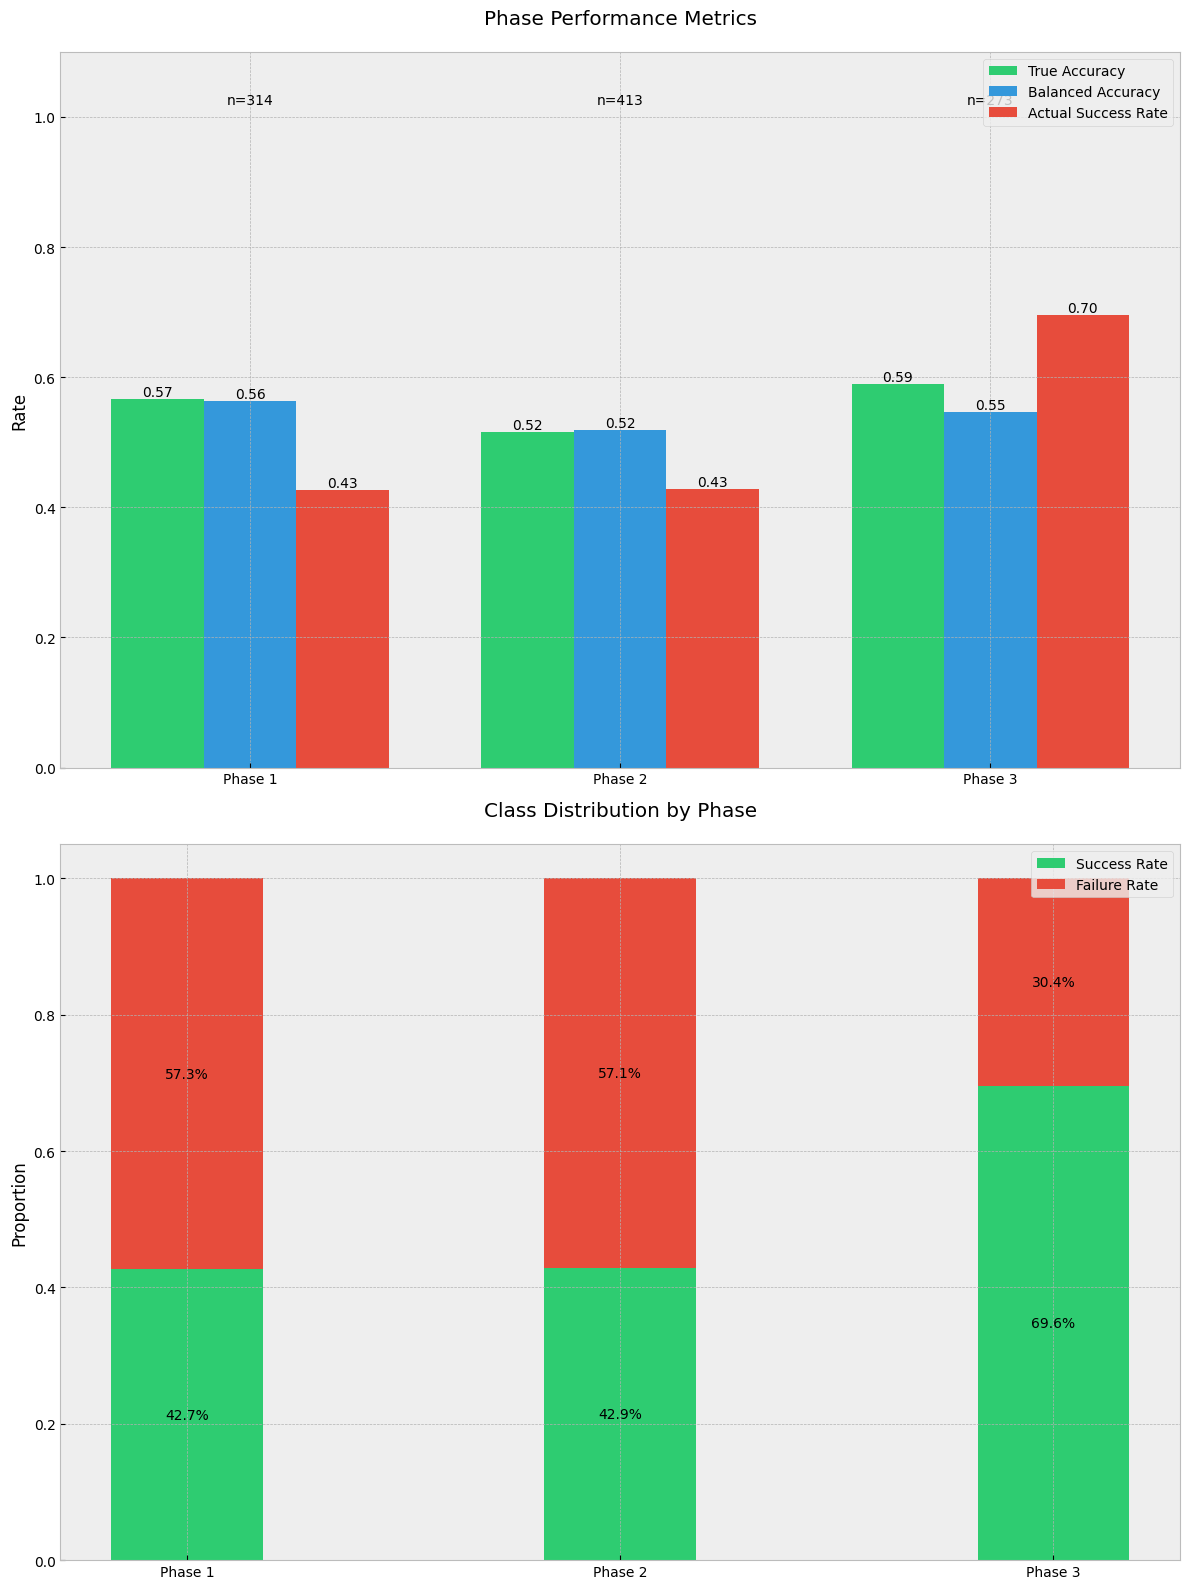

In [61]:
# Example usage:
fig = plot_phase_performance(df_test)
plt.show()

### Saving the model trainer state and model adapters

In [62]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 120046851GF
  train_loss               =      0.9329
  train_runtime            =  1:08:37.69
  train_samples            =        3000
  train_samples_per_second =       1.457
  train_steps_per_second   =       0.091


#### Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [63]:
# 1. Save model and tokenizer locally
output_dir = "saved_medical_model"

# Save the model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('saved_medical_model\\tokenizer_config.json',
 'saved_medical_model\\special_tokens_map.json',
 'saved_medical_model\\tokenizer.json')

In [64]:

# Create a model card with metadata
model_card = """
---
language: en
tags:
- clinical-trials
- llama
- sequence-classification
metrics:
- accuracy
- f1
pipeline_tag: text-classification
---

# Clinical Trial Success Prediction Model

This model is fine-tuned on clinical trial data to predict trial success probabilities across different phases.

## Model description

This is a fine-tuned version of Medical Llama-3 8B optimized for clinical trial success prediction. The model was trained using QLoRA techniques.

## Intended uses & limitations

This model is intended to analyze clinical trial descriptions and predict likelihood of success. It should be used as a supplementary tool and not as the sole decision maker for trial planning.

## Training and Evaluation Data

The model was trained on a dataset of clinical trial records with known outcomes. Performance metrics:

- Overall Accuracy: {accuracy}
- Balanced Accuracy by Phase:
  - Phase 1: {phase1_acc}
  - Phase 2: {phase2_acc}
  - Phase 3: {phase3_acc}

## Training procedure

The model was fine-tuned using QLoRA with the following parameters:
- Learning rate: 1e-4
- Epochs: 2
- Batch size: 8
"""

# Push model and tokenizer to HF Hub
repository_id = "lheitman/MedicalLlama3_8b_CTP_v0"  # Replace with your desired repo name

model.push_to_hub(repository_id, 
                 commit_message="Add clinical trial prediction model",
                 private=True)  # Set to False if you want a public repo
tokenizer.push_to_hub(repository_id, 
                     commit_message="Add tokenizer")

print(f"Model and tokenizer uploaded to: https://huggingface.co/{repository_id}")

# 3. Optional: Save adapter weights only (if using PEFT/LoRA)
# This is much smaller than the full model
model.save_pretrained("adapter_weights", 
                     weights_only=True)

# Later, to load the model:
"""
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load from local
model = AutoModelForSequenceClassification.from_pretrained("saved_model")
tokenizer = AutoTokenizer.from_pretrained("saved_model")

# OR load from HuggingFace Hub
model = AutoModelForSequenceClassification.from_pretrained("your-username/model-name")
tokenizer = AutoTokenizer.from_pretrained("your-username/model-name")

# If you saved only adapter weights:
config = PeftConfig.from_pretrained("adapter_weights")
model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, "adapter_weights")
"""

adapter_model.safetensors: 100%|██████████| 54.6M/54.6M [00:02<00:00, 23.2MB/s]
c:\Users\lh5938a\Desktop\CTP\ctp_env_new\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lh5938a\.cache\huggingface\hub\models--lheitman--MedicalLlama3_8b_CTP_v0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model and tokenizer uploaded to: https://huggingface.co/lheitman/MedicalLlama3_8b_CTP_v0


'\nfrom transformers import AutoModelForSequenceClassification, AutoTokenizer\nfrom peft import PeftModel, PeftConfig\n\n# Load from local\nmodel = AutoModelForSequenceClassification.from_pretrained("saved_model")\ntokenizer = AutoTokenizer.from_pretrained("saved_model")\n\n# OR load from HuggingFace Hub\nmodel = AutoModelForSequenceClassification.from_pretrained("your-username/model-name")\ntokenizer = AutoTokenizer.from_pretrained("your-username/model-name")\n\n# If you saved only adapter weights:\nconfig = PeftConfig.from_pretrained("adapter_weights")\nmodel = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)\nmodel = PeftModel.from_pretrained(model, "adapter_weights")\n'

In [65]:
torch.cuda.empty_cache()

### Load model from huggingface

In [66]:
model_name = "lheitman/MedicalLlama3_8b_CTP_v0"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TsinghuaC3I/Llama-3-8B-UltraMedical and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 23.99 GiB of which 0 bytes is free. Of the allocated memory 22.98 GiB is allocated by PyTorch, and 20.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# Make predictions function
def make_predictions(model, df_test):
    sentences = df_test.trial_information.tolist()
    batch_size = 64
    all_outputs = []
    
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            all_outputs.append(outputs['logits'])
            
    final_outputs = torch.cat(all_outputs, dim=0)
    df_test['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
    df_test['predictions'] = df_test['predictions'].apply(lambda l: category_map[l])
    
    return df_test

# Make predictions
df_test = make_predictions(model, df_test)

# Get metrics using our new function
metrics, phase_metrics = get_performance_metrics(df_test, phase_specific=True)

### Inference from Saved Model

### Next Steps
i'm wondering what the next step might be.

Some initial ideas:

1) add some ability of CoT prompting for the model. Is there a way to give the model more context or ability to reason why these trials are good or bad?

2) error analyses. given I have the weights for this model, is it useful to understand why the model is making these mistakes and on what data the mistakes are being made on. what makes a trial hard to predict vs easy? Or does the model train long enough to kind of get lucky just above a 50/50 coin toss?

#### Just step 2 for now

In [67]:
def perform_error_analysis(df_test, model, tokenizer, device='cuda'):
    """
    Comprehensive error analysis of model predictions
    """
    import torch
    from sklearn.metrics import confusion_matrix
    import numpy as np
    from collections import defaultdict
    
    error_analysis = defaultdict(list)
    
    # 1. Analyze prediction patterns
    for idx, row in df_test.iterrows():
        inputs = tokenizer(row['trial_information'], 
                         return_tensors="pt", 
                         truncation=True, 
                         max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probs.max().item()
        
        true_label = 1 if row['result'] == 'Yes' else 0
        is_correct = prediction == true_label
        
        # Store prediction details
        error_analysis['predictions'].append({
            'idx': idx,
            'true_label': true_label,
            'predicted_label': prediction,
            'confidence': confidence,
            'is_correct': is_correct,
            'text_length': len(row['trial_information'].split()),
            'phase': row['phase']
        })
        
        # If it's an error, store more details
        if not is_correct:
            error_analysis['errors'].append({
                'idx': idx,
                'text': row['trial_information'],
                'true_label': row['result'],
                'confidence': confidence,
                'phase': row['phase']
            })
    
    # Convert to DataFrame for easier analysis
    pred_df = pd.DataFrame(error_analysis['predictions'])
    error_df = pd.DataFrame(error_analysis['errors'])
    
    # 2. Calculate key metrics
    analysis_results = {
        'overall_accuracy': pred_df['is_correct'].mean(),
        'confusion_matrix': confusion_matrix(
            pred_df['true_label'], 
            pred_df['predicted_label']
        ),
        'phase_accuracy': pred_df.groupby('phase')['is_correct'].mean(),
        'confidence_correlation': np.corrcoef(
            pred_df['confidence'], 
            pred_df['is_correct']
        )[0,1],
        'high_confidence_errors': len(
            pred_df[
                (pred_df['confidence'] > 0.9) & 
                (~pred_df['is_correct'])
            ]
        )
    }
    
    return pred_df, error_df, analysis_results

def visualize_error_patterns(pred_df, error_df, analysis_results):
    """
    Create visualizations for error analysis
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Confidence Distribution
    sns.histplot(
        data=pred_df, 
        x='confidence', 
        hue='is_correct', 
        multiple="stack",
        ax=ax1
    )
    ax1.set_title('Confidence Distribution (Correct vs Incorrect)')
    
    # 2. Phase-wise Error Analysis
    phase_errors = pred_df.groupby(['phase', 'is_correct']).size().unstack()
    phase_errors.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Errors by Phase')
    
    # 3. Text Length vs Accuracy
    sns.boxplot(
        data=pred_df, 
        x='is_correct', 
        y='text_length',
        ax=ax3
    )
    ax3.set_title('Text Length vs Prediction Accuracy')
    
    # 4. Confusion Matrix
    sns.heatmap(
        analysis_results['confusion_matrix'], 
        annot=True, 
        fmt='d',
        ax=ax4
    )
    ax4.set_title('Confusion Matrix')
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('True')
    
    plt.tight_layout()
    return fig

def analyze_difficult_cases(error_df):
    """
    Analyze patterns in difficult cases
    """
    # Sort by confidence to find most confident mistakes
    high_confidence_errors = error_df.sort_values('confidence', ascending=False)
    
    # Analyze common phrases or patterns in errors
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Extract common n-grams from error cases
    vectorizer = CountVectorizer(ngram_range=(2, 3))
    X = vectorizer.fit_transform(high_confidence_errors['text'])
    
    # Get most common phrases in errors
    feature_names = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    
    common_phrases = pd.DataFrame({
        'phrase': feature_names,
        'count': counts
    }).sort_values('count', ascending=False)
    
    return high_confidence_errors, common_phrases



In [68]:
# Perform analysis
pred_df, error_df, analysis_results = perform_error_analysis(df_test, model, tokenizer)

# Generate visualizations
fig = visualize_error_patterns(pred_df, error_df, analysis_results)
plt.show()

# Analyze difficult cases
high_conf_errors, common_phrases = analyze_difficult_cases(error_df)

print("Most common phrases in errors:")
print(common_phrases.head(10))

print("\nHigh confidence errors:")
for _, error in high_conf_errors.head().iterrows():
    print(f"\nConfidence: {error['confidence']:.2f}")
    print(f"True label: {error['true_label']}")
    print(f"Phase: {error['phase']}")
    print("Text excerpt:", error['text'][:200], "...")


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.99 GiB of which 0 bytes is free. Of the allocated memory 22.99 GiB is allocated by PyTorch, and 8.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [109]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import chi2_contingency
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

def create_clinical_stopwords():
    """Create a list of stopwords including common clinical trial terms."""
    basic_stops = list(stopwords.words('english'))
    clinical_stops = [
        'inclusion', 'exclusion', 'criteria', 'study', 'trial', 'patient', 'patients',
        'subjects', 'subject', 'day', 'days', 'week', 'weeks', 'month', 'months',
        'criteria', 'following', 'must', 'will', 'may', 'protocol', 'according',
        'investigator', 'participation', 'participate', 'treatment', 'therapy',
        'visit', 'visits', 'screening', 'eligible', 'eligibility', 'requirements',
        'required', 'following', 'prior', 'using', 'used', 'received', 'receiving'
    ]
    return basic_stops + clinical_stops

def safe_chi2_contingency(contingency):
    """
    Safely calculate chi-square statistics, handling zero frequencies.
    """
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency)
        return chi2, p_value
    except ValueError:
        return 0, 1.0  # Return no significance when calculation fails

def analyze_phrase_differences(error_df, correct_df, min_count=5, max_features=1000):
    """
    Analyze differences in phrase frequencies between errors and correct predictions.
    """
    # Get stopwords as list
    stops = create_clinical_stopwords()
    
    # Create vectorizer for 2-3 word phrases
    vectorizer = CountVectorizer(
        ngram_range=(2, 3),
        stop_words=stops,
        max_features=max_features,
        min_df=min_count/len(df_test)  # Changed to use total dataset size
    )
    
    # Fit and transform both sets
    error_counts = vectorizer.fit_transform(error_df['trial_information'])
    correct_counts = vectorizer.transform(correct_df['trial_information'])
    
    # Get feature names
    features = vectorizer.get_feature_names_out()
    
    # Calculate frequencies and statistics
    results = []
    
    for idx, phrase in enumerate(features):
        # Get counts
        error_count = error_counts[:, idx].sum()
        correct_count = correct_counts[:, idx].sum()
        
        # Skip phrases that are too rare
        if error_count + correct_count < min_count:
            continue
            
        # Calculate frequencies
        error_freq = error_count / len(error_df)
        correct_freq = correct_count / len(correct_df)
        
        # Skip if phrase is too rare in either category
        if error_freq < 0.01 and correct_freq < 0.01:
            continue
        
        # Calculate enrichment with smoothing to avoid division by zero
        smoothing = 0.5  # Laplace smoothing
        enrichment = ((error_count + smoothing) / len(error_df)) / ((correct_count + smoothing) / len(correct_df))
        
        # Create contingency table
        contingency = np.array([
            [error_count, len(error_df) - error_count],
            [correct_count, len(correct_df) - correct_count]
        ])
        
        # Safely calculate chi-square statistics
        chi2, p_value = safe_chi2_contingency(contingency)
        
        results.append({
            'phrase': phrase,
            'error_count': error_count,
            'correct_count': correct_count,
            'error_freq': error_freq,
            'correct_freq': correct_freq,
            'enrichment': enrichment,
            'chi2': chi2,
            'p_value': p_value
        })
    
    # Convert to DataFrame and sort by enrichment and significance
    results_df = pd.DataFrame(results)
    results_df['significant'] = results_df['p_value'] < 0.05
    
    # Sort by a combination of significance and effect size
    results_df['effect_score'] = results_df['chi2'] * abs(np.log2(results_df['enrichment']))
    results_df = results_df.sort_values('effect_score', ascending=False)
    
    return results_df

def print_comparative_analysis(results_df, n_top=20):
    """Print top differentiating phrases with their statistics."""
    print("\nTop Phrases More Common in Errors (with significance):")
    error_enriched = results_df[
        (results_df['enrichment'] > 1) & 
        (results_df['significant'])
    ].head(n_top)
    
    for _, row in error_enriched.iterrows():
        print(f"{row['phrase']:<30} "
              f"(Error: {row['error_freq']:.1%} vs Correct: {row['correct_freq']:.1%}, "
              f"Enrichment: {row['enrichment']:.2f}, "
              f"p: {row['p_value']:.3f})")
    
    print("\nTop Phrases More Common in Correct Predictions (with significance):")
    correct_enriched = results_df[
        (results_df['enrichment'] < 1) & 
        (results_df['significant'])
    ].sort_values('enrichment').head(n_top)
    
    for _, row in correct_enriched.iterrows():
        print(f"{row['phrase']:<30} "
              f"(Error: {row['error_freq']:.1%} vs Correct: {row['correct_freq']:.1%}, "
              f"Enrichment: {1/row['enrichment']:.2f}, "
              f"p: {row['p_value']:.3f})")

def analyze_errors_enhanced(df_test):
    """
    Enhanced error analysis with comparative phrase analysis.
    """
    # Separate errors and correct predictions
    errors = df_test[df_test['predictions'] != df_test['result']]
    correct = df_test[df_test['predictions'] == df_test['result']]
    
    print(f"\nTotal predictions: {len(df_test)}")
    print(f"Errors: {len(errors)} ({len(errors)/len(df_test):.1%})")
    print(f"Correct: {len(correct)} ({len(correct)/len(df_test):.1%})")
    
    # Analyze phrase differences
    results_df = analyze_phrase_differences(errors, correct)
    
    # Print comparative analysis
    print_comparative_analysis(results_df)
    
    # Additional phase-specific analysis
    print("\nPhase-wise Error Analysis:")
    phase_error_rates = df_test.groupby('phase').apply(
        lambda x: (x['predictions'] != x['result']).mean()
    )
    print("\nError rates by phase:")
    for phase, rate in phase_error_rates.items():
        print(f"Phase {phase}: {rate:.1%}")
    
    return results_df

In [ ]:
# Run the enhanced analysis
results_df = analyze_errors_enhanced(df_test)

# Save the most significant results
significant_results = results_df[results_df['significant']].copy()
significant_results.to_csv('significant_phrases.csv')



Total predictions: 1000
Errors: 409 (40.9%)
Correct: 591 (59.1%)

Top Phrases More Common in Errors (with significance):
final drug                     (Error: 3.2% vs Correct: 0.0%, Enrichment: 39.01, p: 0.000)
final drug administration      (Error: 3.2% vs Correct: 0.0%, Enrichment: 39.01, p: 0.000)
drug whichever longer          (Error: 2.9% vs Correct: 0.0%, Enrichment: 36.12, p: 0.000)
drug whichever                 (Error: 2.9% vs Correct: 0.0%, Enrichment: 36.12, p: 0.000)
clinical unit                  (Error: 4.4% vs Correct: 0.3%, Enrichment: 10.69, p: 0.000)
admission clinical             (Error: 3.4% vs Correct: 0.2%, Enrichment: 13.97, p: 0.000)
admission clinical unit        (Error: 3.4% vs Correct: 0.2%, Enrichment: 13.97, p: 0.000)
dose imp                       (Error: 4.2% vs Correct: 0.3%, Enrichment: 10.11, p: 0.000)
pain intensity                 (Error: 5.4% vs Correct: 1.0%, Enrichment: 5.00, p: 0.000)
ml blood                       (Error: 3.2% vs Correct: 0.3%

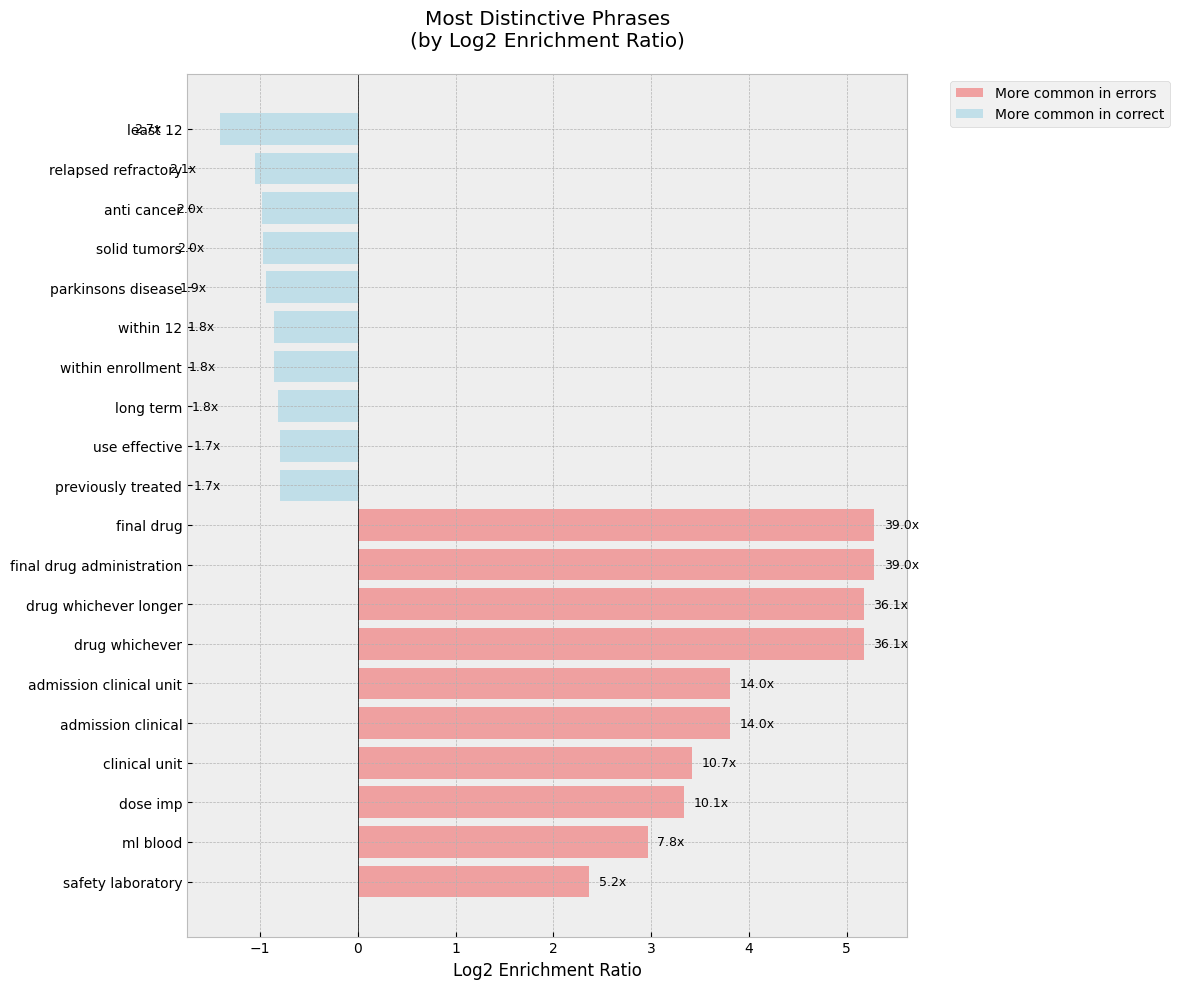

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phrase_enrichment(results_df, n_phrases=10):
    """
    Create a horizontal bar plot showing the most enriched phrases in errors and correct predictions.
    
    Args:
        results_df: DataFrame with phrase analysis results
        n_phrases: Number of top phrases to show for each category
    """
    # Get significant phrases only
    significant_results = results_df[results_df['p_value'] < 0.05]
    
    # Get top phrases for errors and correct predictions
    error_phrases = (significant_results[significant_results['enrichment'] > 1]
                    .sort_values('enrichment', ascending=True)
                    .tail(n_phrases))
    
    correct_phrases = (significant_results[significant_results['enrichment'] < 1]
                      .sort_values('enrichment', ascending=False)
                      .tail(n_phrases))
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Plot bars for error-enriched phrases (red)
    y_pos_error = np.arange(len(error_phrases))
    plt.barh(y_pos_error, 
            np.log2(error_phrases['enrichment']),
            color='lightcoral',
            alpha=0.7,
            label='More common in errors')
    
    # Plot bars for correct-enriched phrases (blue)
    y_pos_correct = np.arange(len(error_phrases), len(error_phrases) + len(correct_phrases))
    plt.barh(y_pos_correct,
            -np.log2(1/correct_phrases['enrichment']),  # Negative log2 for correct predictions
            color='lightblue',
            alpha=0.7,
            label='More common in correct')
    
    # Add phrases as y-axis labels
    plt.yticks(np.arange(2*n_phrases),
              list(error_phrases['phrase']) + list(correct_phrases['phrase']),
              fontsize=10)
    
    # Customize plot
    plt.title('Most Distinctive Phrases\n(by Log2 Enrichment Ratio)', pad=20)
    plt.xlabel('Log2 Enrichment Ratio')
    
    # Add a vertical line at x=0
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add value labels on the bars
    for i, enrichment in enumerate(np.log2(error_phrases['enrichment'])):
        plt.text(enrichment + 0.1, i, f'{2**enrichment:.1f}x', 
                va='center', fontsize=9)
    
    for i, enrichment in enumerate(-np.log2(1/correct_phrases['enrichment'])):
        plt.text(enrichment - 0.6, i + len(error_phrases), f'{1/(2**enrichment):.1f}x', 
                va='center', ha='right', fontsize=9)
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

fig = plot_phrase_enrichment(results_df)
plt.show()

# Optionally save the figure
# plt.savefig('phrase_enrichment.png', bbox_inches='tight', dpi=300)
